# 10x Visium

In [45]:
import warnings
warnings.filterwarnings("ignore")

In [46]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn.metrics.cluster import adjusted_rand_score

In [47]:
import BINARY

In [48]:
import pysodb
sodb = pysodb.SODB()

In [49]:
# Define names of the dataset_name and experiment_name
dataset_name = 'maynard2021trans'
experiment_name = '151673'
# Load a specific experiment
# It takes two arguments: the name of the dataset and the name of the experiment to load.
# Two arguments are available at https://gene.ai.tencent.com/SpatialOmics/.
adata_raw = sodb.load_experiment(dataset_name,experiment_name)

load experiment[151673] in dataset[maynard2021trans]


In [50]:
adata = adata_raw.copy()

In [51]:
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Region', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [52]:
adata.var_names_make_unique()

In [53]:
adata = BINARY.Count2Binary(adata)

In [54]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=2000) 

In [55]:
BINARY.Construct_Spatial_Graph(adata, use_method='KNN', cutoff=6)
#BINARY.Construct_Spatial_Graph(adata, use_model='Radius', cutoff = 150)

------Constructing spatial graph...------
The graph contains 21834 edges, 3639 cells.
6.0000 neighbors per cell on average.


In [56]:
adata = BINARY.train_BINARY(adata, pos_weight = 10, device= 'cuda:0')

Size of Input:  (3639, 2000)


100%|██████████| 1000/1000 [00:13<00:00, 72.66it/s]


In [57]:
sc.pp.neighbors(adata, use_rep='BINARY')
sc.tl.umap(adata)

In [58]:
adata = BINARY.mclust_R(adata, used_obsm='BINARY', num_cluster=7)

fitting ...
  |                                                                      |   0%

  |======================================================================| 100%


In [59]:
obs_df = adata.obs.dropna()
ARI = adjusted_rand_score(obs_df['mclust'], obs_df['Region'])
print('Adjusted rand index = %.2f' %ARI)

Adjusted rand index = 0.59


In [60]:
NMI = normalized_mutual_info_score(obs_df['mclust'], obs_df['Region'])
print('NMI = %.2f' %NMI)

NMI = 0.71


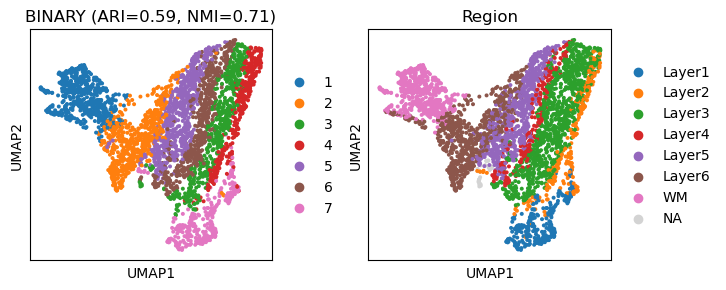

In [61]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color=["mclust", "Region"], title=['BINARY (ARI=%.2f, NMI=%.2f)'%(ARI, NMI), "Region"])

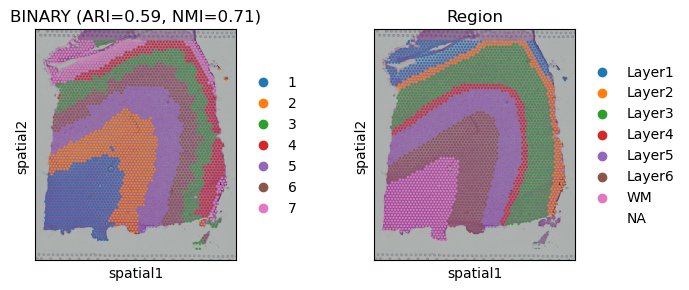

In [62]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, color=["mclust", "Region"], title=['BINARY (ARI=%.2f, NMI=%.2f)'%(ARI, NMI), "Region"])

In [63]:
new_type = BINARY.Refine_label(adata, radius=30, key='mclust')
adata.obs['domain'] = new_type 

In [64]:
obs_df = adata.obs.dropna()
refine_ARI = adjusted_rand_score(obs_df['domain'], obs_df['Region'])
print('Refine ARI = %.2f' %refine_ARI)

Refine ARI = 0.60


In [65]:
from sklearn.metrics import *
refine_NMI = normalized_mutual_info_score(obs_df['domain'], obs_df['Region'])
print('NMI = %.2f' %refine_NMI)

NMI = 0.72


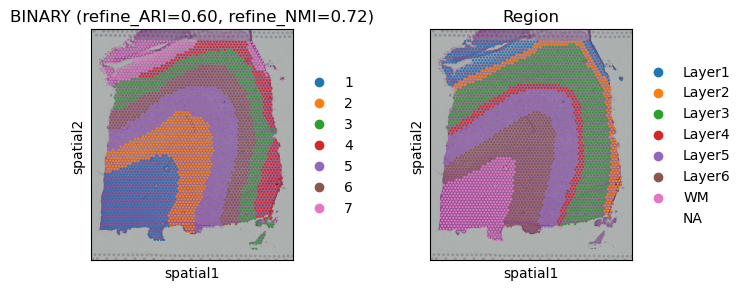

In [66]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, color=['domain', "Region"], title=['BINARY (refine_ARI=%.2f, refine_NMI=%.2f)'%(refine_ARI, refine_NMI), "Region"])